# Example Burgers' equation

In [3]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
from math import pi as PI
from math import exp as exp
# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.library_functions import library_1D_in
from deepymod_torch.training import train_deepmod, train_mse, train_group

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [4]:


def analytical_solution(NT, NX, TMAX, XMAX, NU):
   """
   Returns the velocity field and distance for the analytical solution
   """

   # Increments
   DT = TMAX/(NT-1)
   DX = XMAX/(NX-1)

   # Initialise data structures
   import numpy as np
   u_analytical = np.zeros((NX,NT))
   x = np.zeros(NX)
   t = np.zeros(NT)

   # Distance
   for i in range(0,NX):
       x[i] = i*DX

   # Analytical Solution
   for n in range(0,NT):
       t = n*DT

       for i in range(0,NX):
           phi = exp( -(x[i]-4*t)**2/(4*NU*(t+1)) ) + exp( -(x[i]-4*t-2*PI)**2/(4*NU*(t+1)) )

           dphi = ( -0.5*(x[i]-4*t)/(NU*(t+1))*exp( -(x[i]-4*t)**2/(4*NU*(t+1)) )
               -0.5*(x[i]-4*t-2*PI)/(NU*(t+1))*exp( -(x[i]-4*t-2*PI)**2/(4*NU*(t+1)) ) )

           u_analytical[i,n] = -2*NU*(dphi/phi) + 4

   return u_analytical, x

In [5]:
NT = 101
TMax = 2
dt = TMax/NT

In [6]:
u_analytical,x = analytical_solution(NT, 151, TMax, 2.0*PI, 0.25)
x_array = np.squeeze(np.array([x.reshape(-1,1) for i in np.arange(u_analytical.shape[1])]))
t_array = np.array([i*dt*np.ones(u_analytical.shape[0]) for i in np.arange(u_analytical.shape[1])])
u_analytical= u_analytical.T

In [7]:
u_analytical_b,x = analytical_solution(NT, 151, TMax, 2.0*PI, 0.1)
u_analytical_b= u_analytical_b.T

In [8]:
u_analytical_c,x = analytical_solution(NT, 151, TMax, 2.0*PI, 0.15)
u_analytical_c= u_analytical_c.T

In [9]:
t_array.shape

(101, 151)

Next, we prepare the dataset.

Let's plot it to get an idea of the data:

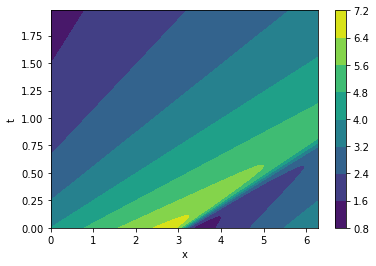

In [10]:
fig, ax = plt.subplots()
im = ax.contourf(x_array, t_array, u_analytical)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

In [11]:
X = np.transpose((t_array.flatten(), x_array.flatten()))
y = np.real(np.transpose((u_analytical.flatten(),u_analytical_b.flatten(), u_analytical_c.flatten())))
print(X.shape, y.shape)

(15251, 2) (15251, 3)


In [25]:
y = np.real(u_analytical).reshape((u_analytical.size, 1))

As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. This dataset is noiseless, so let's add $5\%$ noise:

In [12]:
noise_level = 0.02
y_noisy = y + noise_level * np.std(y) * np.random.randn(y[:,0].size, 1)

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [13]:
y.shape[0]

15251

In [14]:
number_of_samples = 600

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

In [15]:
print(X_train.shape, y_train.shape)

torch.Size([600, 2]) torch.Size([600, 3])


We now have a dataset which we can use. Let's plot, for a final time, the original dataset, the noisy set and the samples points:

## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [16]:
from deepymod_torch.library_functions import library_deriv, library_poly

In [17]:
def library_1D(input, poly_order, diff_order):
    prediction, data = input
    poly_list = []
    deriv_list = []
    time_deriv_list = []
   
    # Creating lists for all outputs
    for output in torch.arange(prediction.shape[1]):
        time_deriv, du = library_deriv(data, prediction[:, output:output+1], diff_order)
        u = library_poly(prediction[:, output:output+1], poly_order)

        poly_list.append(u)
        deriv_list.append(du)
        time_deriv_list.append(time_deriv)

    samples = time_deriv_list[0].shape[0]
    total_terms = poly_list[0].shape[1] * deriv_list[0].shape[1]
    
    # Calculating theta
    theta_1 = torch.matmul(poly_list[0][:, :, None], deriv_list[0][:, None, :]).view(samples, total_terms)

    return time_deriv_list, [theta_1]


In [31]:
def library_1D(input, poly_order, diff_order):
    prediction, data = input
    poly_list = []
    deriv_list = []
    time_deriv_list = []
   
    # Creating lists for all outputs
    for output in torch.arange(prediction.shape[1]):
        time_deriv, du = library_deriv(data, prediction[:, output:output+1], diff_order)
        u = library_poly(prediction[:, output:output+1], poly_order)

        poly_list.append(u)
        deriv_list.append(du)
        time_deriv_list.append(time_deriv)

    samples = time_deriv_list[0].shape[0]
    total_terms = poly_list[0].shape[1] * deriv_list[0].shape[1]
    
    # Calculating theta
    theta_1 = torch.matmul(poly_list[0][:, :, None], deriv_list[0][:, None, :]).view(samples, total_terms)
    theta_2 = torch.matmul(poly_list[1][:, :, None], deriv_list[1][:, None, :]).view(samples, total_terms)
    theta_3 = torch.matmul(poly_list[2][:, :, None], deriv_list[2][:, None, :]).view(samples, total_terms)

    return time_deriv_list, [theta_1, theta_2, theta_3]


In [32]:
## Running DeepMoD
config = {'n_in': 2, 'hidden_dims': [30, 30,30, 30], 'n_out': 3, 'library_function': library_1D, 'library_args':{'poly_order': 2, 'diff_order': 2}}

Now we instantiate the model:

In [33]:
model = DeepMod(**config)
optimizer = torch.optim.Adam([{'params': model.network_parameters(), 'lr':0.001}, {'params': model.coeff_vector(), 'lr':0.005}],betas=(0.99,0.99))

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [34]:
train_group(model, X_train, y_train, optimizer, 20000, {'l1': 1e-3, 'l2': 1e-9})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |       Lg |
      20000    100.00%               0s   6.18e-03   1.66e-03   3.48e-04   4.18e-03, 4.18e-09 

Now that DeepMoD has converged, it has found the following numbers:

In [35]:
print(model.fit.coeff_vector[0])

Parameter containing:
tensor([[ 1.1604e-01],
        [-5.4405e-01],
        [ 2.2890e-01],
        [-6.0734e-05],
        [-8.3461e-01],
        [ 8.5446e-06],
        [-7.6643e-03],
        [-8.9068e-03],
        [-1.9008e-05]], requires_grad=True)


In [30]:
print(model.fit.coeff_vector[0])

Parameter containing:
tensor([[-7.0982e-05],
        [-3.2813e-01],
        [ 2.3042e-01],
        [-1.7332e-04],
        [-7.9427e-01],
        [-4.3468e-05],
        [-1.0552e-02],
        [-1.3158e-02],
        [-5.6731e-05]], requires_grad=True)
